# 02 - Exploratory Data Analysis and Preprocessing

This notebook performs comprehensive EDA and preprocessing including:
1. Time series decomposition (trend, seasonality, residuals)
2. Missing value handling strategies
3. Outlier treatment
4. Feature engineering (lags, rolling stats, temporal features)
5. Data transformation and normalization
6. Train/validation/test split

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yaml

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

from src.data.load_data import load_raw, basic_clean
from src.utils.seed import set_seed

# Load config
with open('../config/project.yaml') as f:
    config = yaml.safe_load(f)

set_seed(config['random_seed'])
print("Libraries imported and seed set")

Libraries imported and seed set


## 1. Load and Clean Data

In [2]:
# Load raw data
df = load_raw('../dataset/household_power_consumption.txt')
df = basic_clean(df)

print(f"Shape after basic cleaning: {df.shape}")
print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")

# Set DateTime as index
df.set_index('DateTime', inplace=True)
df.head()

Shape after basic cleaning: (2049280, 8)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## 2. Aggregate to Daily Data

For practical forecasting and computational efficiency, we aggregate minute-level data to daily totals.

In [3]:
# Aggregate to daily data
target = config['project']['target_variable']

# Daily aggregation - mean for power, sum for sub-metering
daily_df = df.resample('D').agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

print(f"Daily data shape: {daily_df.shape}")
print(f"Date range: {daily_df.index.min()} to {daily_df.index.max()}")
print(f"Total days: {len(daily_df)}")
daily_df.head()

Daily data shape: (1442, 7)
Date range: 2006-12-16 00:00:00 to 2010-11-26 00:00:00
Total days: 1442


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0
2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0
2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0
2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.0,2648.0,14063.0


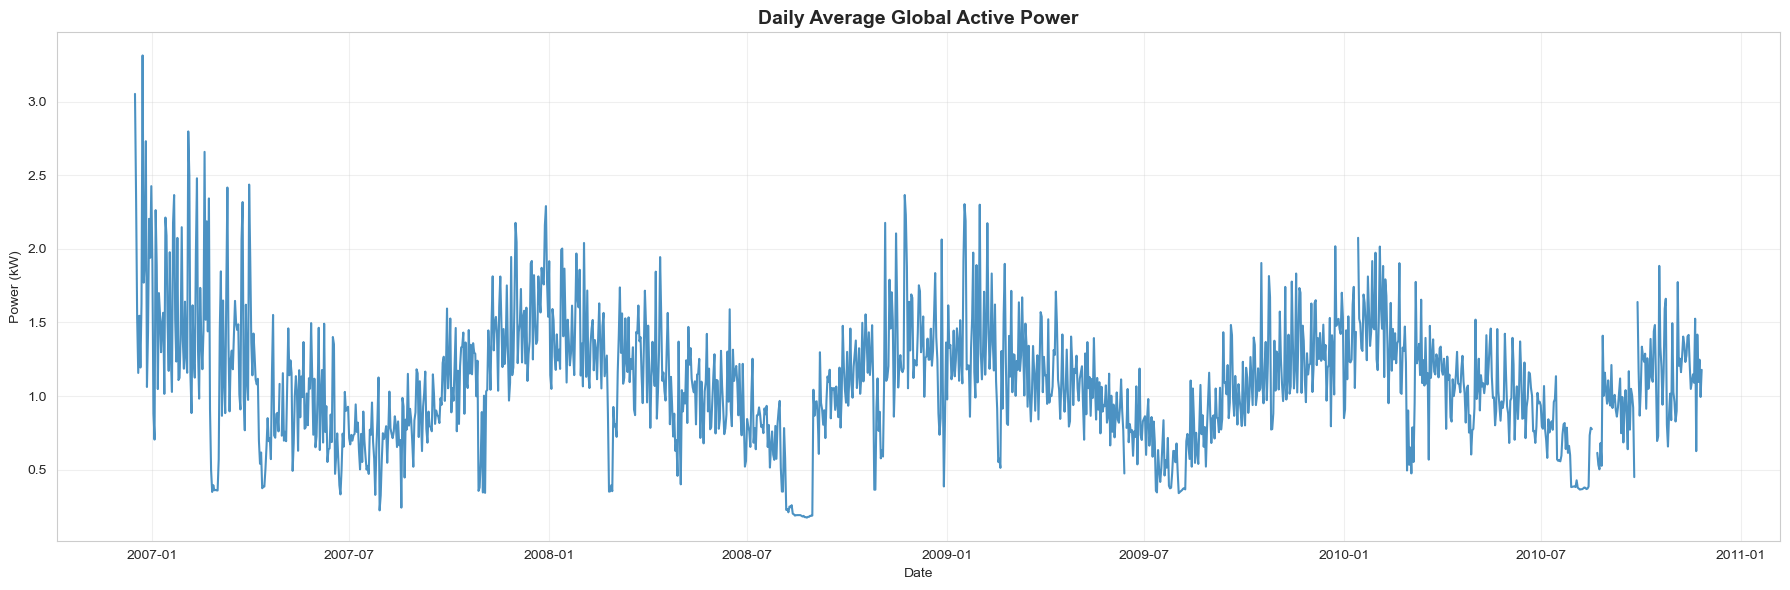

In [4]:
# Visualize daily series
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_df.index, daily_df[target], linewidth=1.5, alpha=0.8)
ax.set_title('Daily Average Global Active Power', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Handle Missing Values

In [5]:
# Check for missing values in daily data
missing_info = pd.DataFrame({
    'Missing Count': daily_df.isnull().sum(),
    'Missing Percentage': (daily_df.isnull().sum() / len(daily_df)) * 100
})
print(missing_info)

# Interpolate missing values
daily_df_filled = daily_df.interpolate(method='time', limit_direction='both')
print(f"\nMissing values after interpolation:")
print(daily_df_filled.isnull().sum())

                       Missing Count  Missing Percentage
Global_active_power                9            0.624133
Global_reactive_power              9            0.624133
Voltage                            9            0.624133
Global_intensity                   9            0.624133
Sub_metering_1                     0            0.000000
Sub_metering_2                     0            0.000000
Sub_metering_3                     0            0.000000

Missing values after interpolation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


## 4. Time Series Decomposition

Decompose the series into trend, seasonal, and residual components.

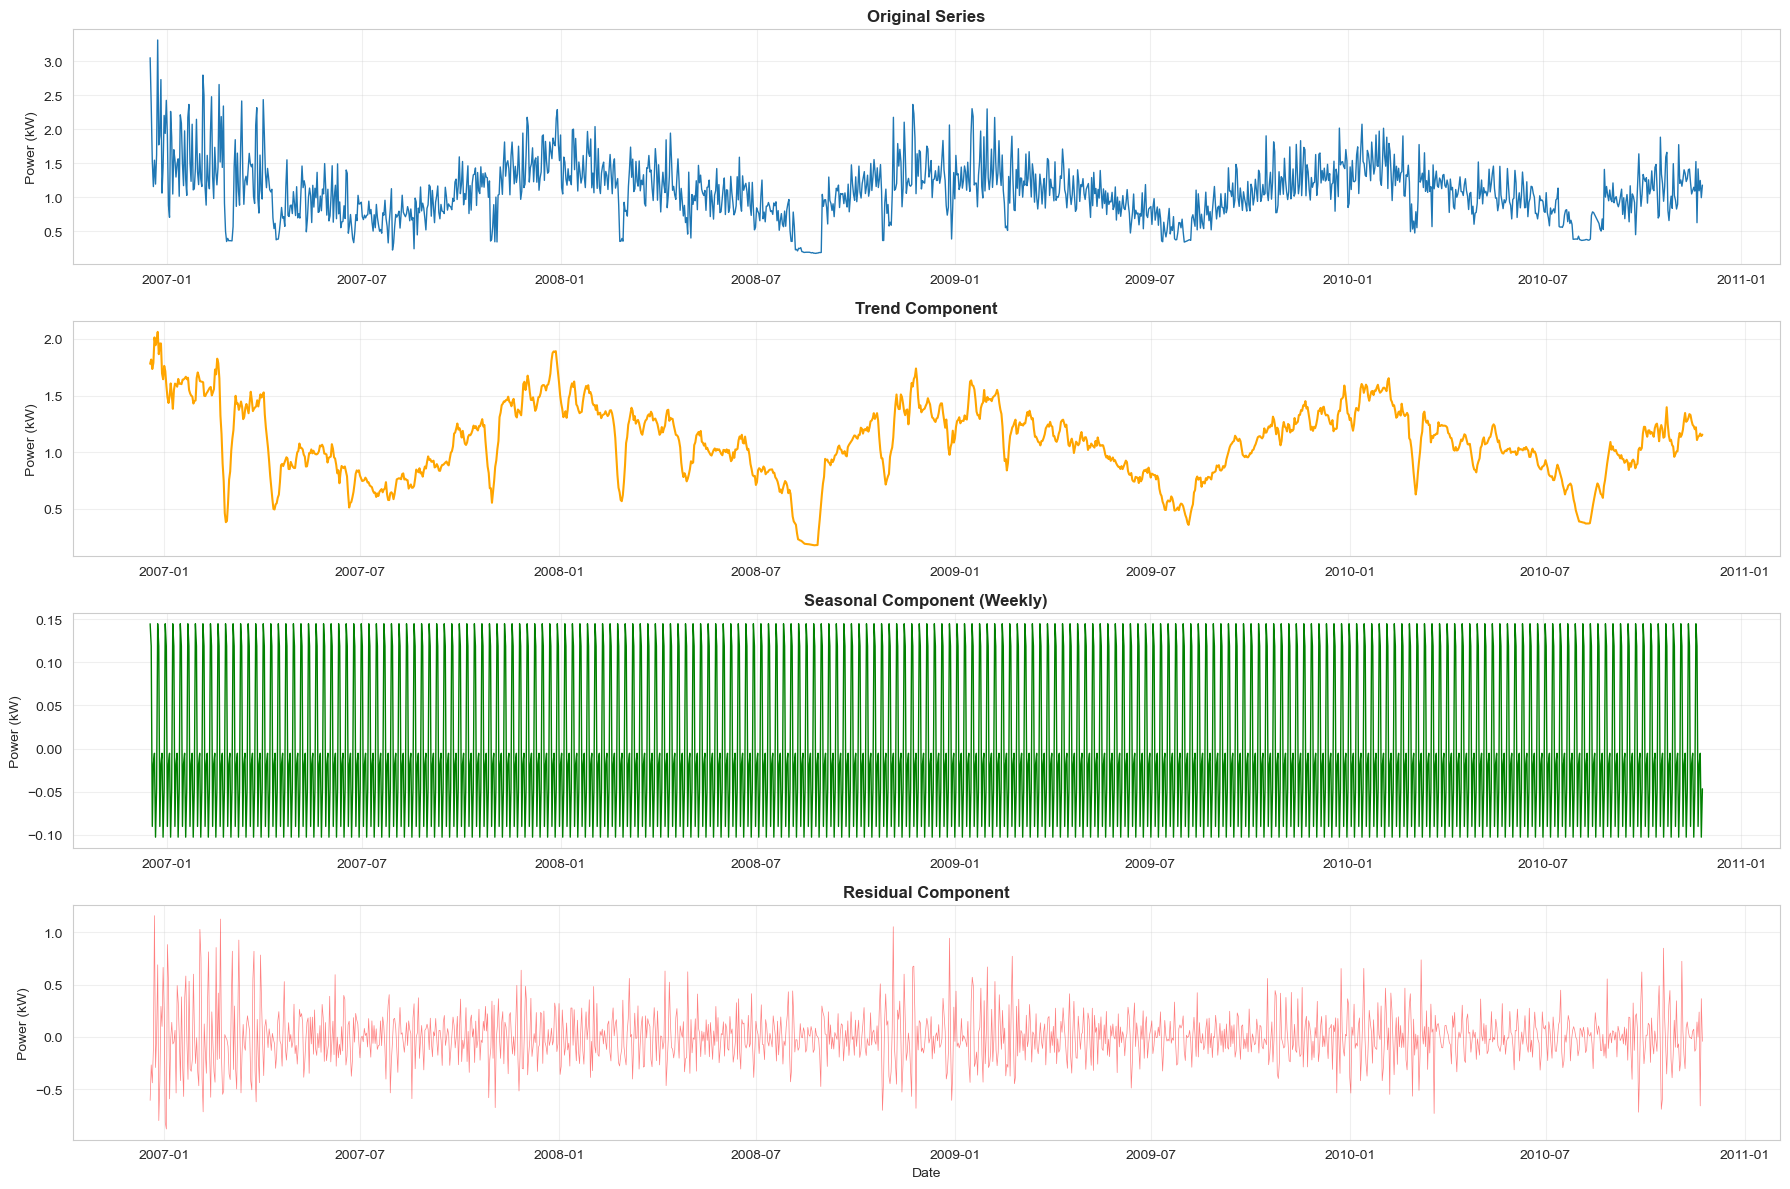

In [6]:
# Perform seasonal decomposition (additive model)
# Use weekly seasonality (period=7 for daily data)
decomposition = seasonal_decompose(daily_df_filled[target], model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(18, 12))

# Original
axes[0].plot(daily_df_filled.index, daily_df_filled[target], linewidth=1)
axes[0].set_title('Original Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, linewidth=1.5, color='orange')
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Power (kW)')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, linewidth=1, color='green')
axes[2].set_title('Seasonal Component (Weekly)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Power (kW)')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid, linewidth=0.5, alpha=0.5, color='red')
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Power (kW)')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Analyze decomposition components
print("Decomposition Statistics:\n")
print(f"Trend Strength: {1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var()):.4f}")
print(f"Seasonal Strength: {1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var()):.4f}")
print(f"\nResidual Statistics:")
print(decomposition.resid.describe())

Decomposition Statistics:

Trend Strength: 0.6441
Seasonal Strength: 0.1202

Residual Statistics:
count    1436.000000
mean       -0.000461
std         0.242617
min        -0.878307
25%        -0.139832
50%        -0.008091
75%         0.126363
max         1.157642
Name: resid, dtype: float64


## 5. Stationarity Tests

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, name='Series'):
    """Perform ADF and KPSS tests for stationarity"""
    series = series.dropna()
    
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    print(f"\n{name} - Augmented Dickey-Fuller Test:")
    print(f"  ADF Statistic: {adf_result[0]:.6f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.3f}")
    print(f"  Conclusion: {'Stationary' if adf_result[1] < 0.05 else 'Non-stationary'}")
    
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"\n{name} - KPSS Test:")
    print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"  p-value: {kpss_result[1]:.6f}")
    print(f"  Conclusion: {'Stationary' if kpss_result[1] > 0.05 else 'Non-stationary'}")

# Test original series
test_stationarity(daily_df_filled[target], 'Original Series')

# Test first difference
diff_series = daily_df_filled[target].diff().dropna()
test_stationarity(diff_series, 'First Difference')


Original Series - Augmented Dickey-Fuller Test:
  ADF Statistic: -3.665697
  p-value: 0.004622
  Critical Values:
    1%: -3.435
    5%: -2.864
    10%: -2.568
  Conclusion: Stationary

Original Series - KPSS Test:
  KPSS Statistic: 0.212443
  p-value: 0.100000
  Conclusion: Stationary

First Difference - Augmented Dickey-Fuller Test:
  ADF Statistic: -11.049452
  p-value: 0.000000
  Critical Values:
    1%: -3.435
    5%: -2.864
    10%: -2.568
  Conclusion: Stationary

First Difference - KPSS Test:
  KPSS Statistic: 0.180184
  p-value: 0.100000
  Conclusion: Stationary


## 6. Autocorrelation Analysis

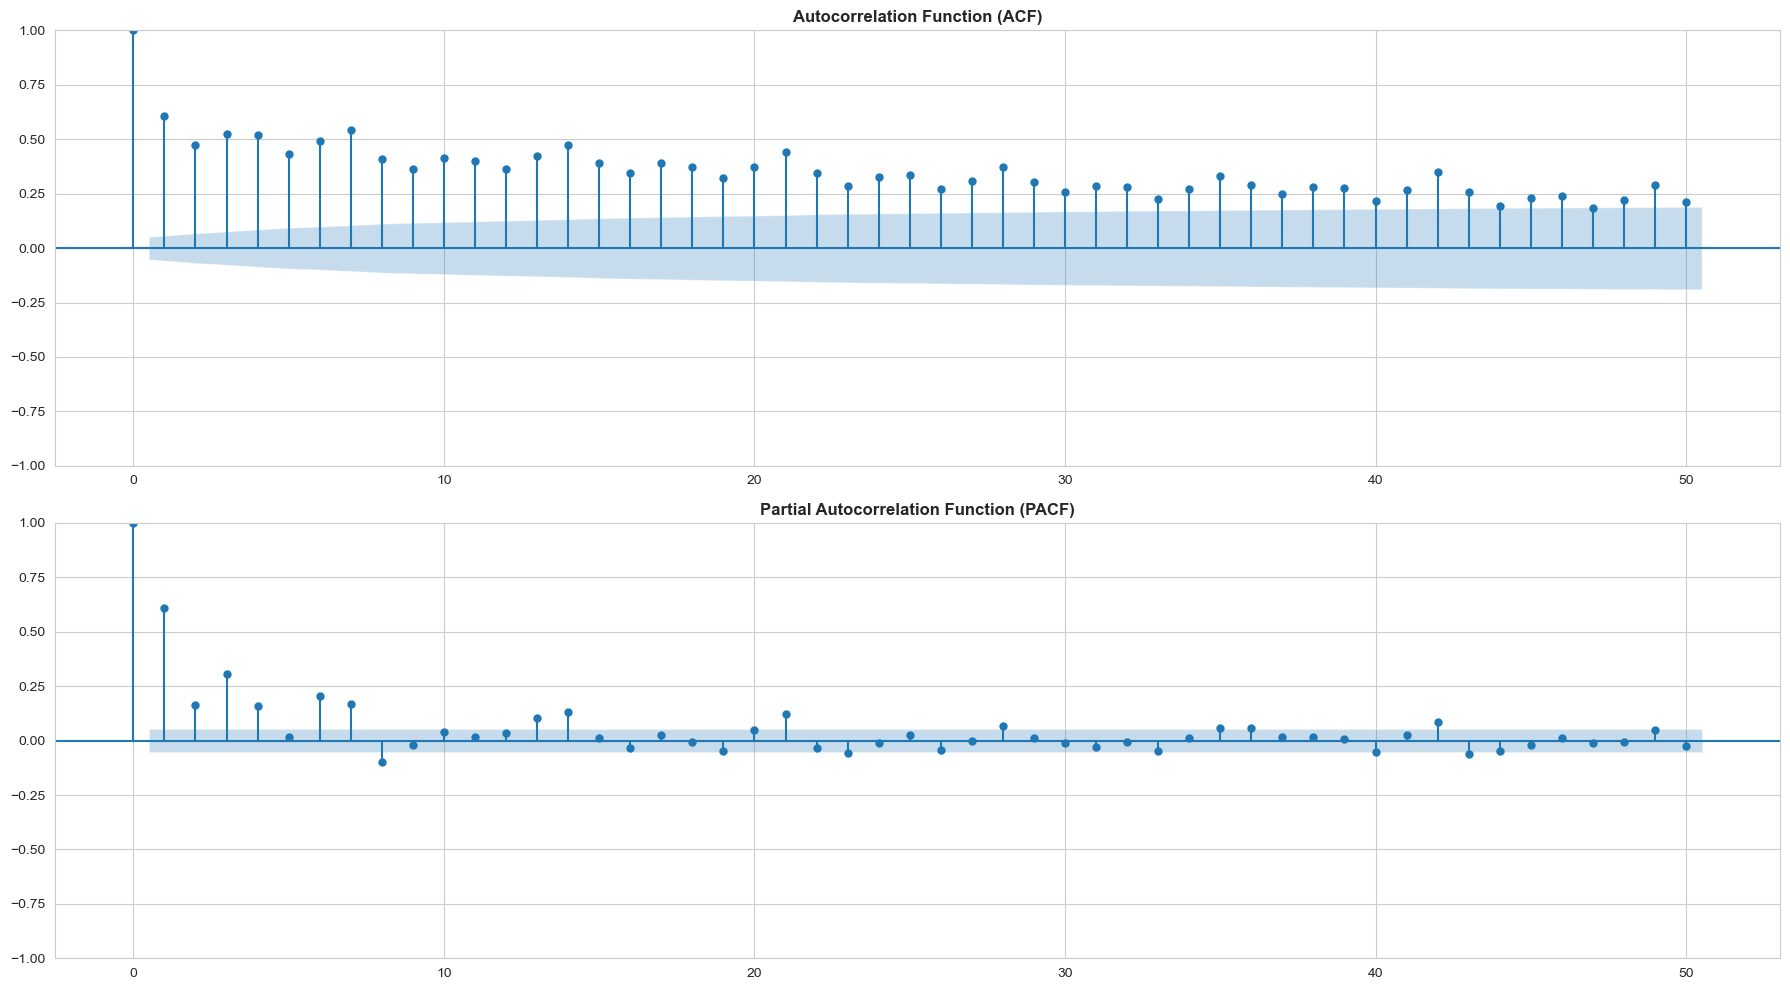

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# ACF
plot_acf(daily_df_filled[target].dropna(), lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# PACF
plot_pacf(daily_df_filled[target].dropna(), lags=50, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Outlier Detection and Handling

Outliers detected: 2 (0.14%)


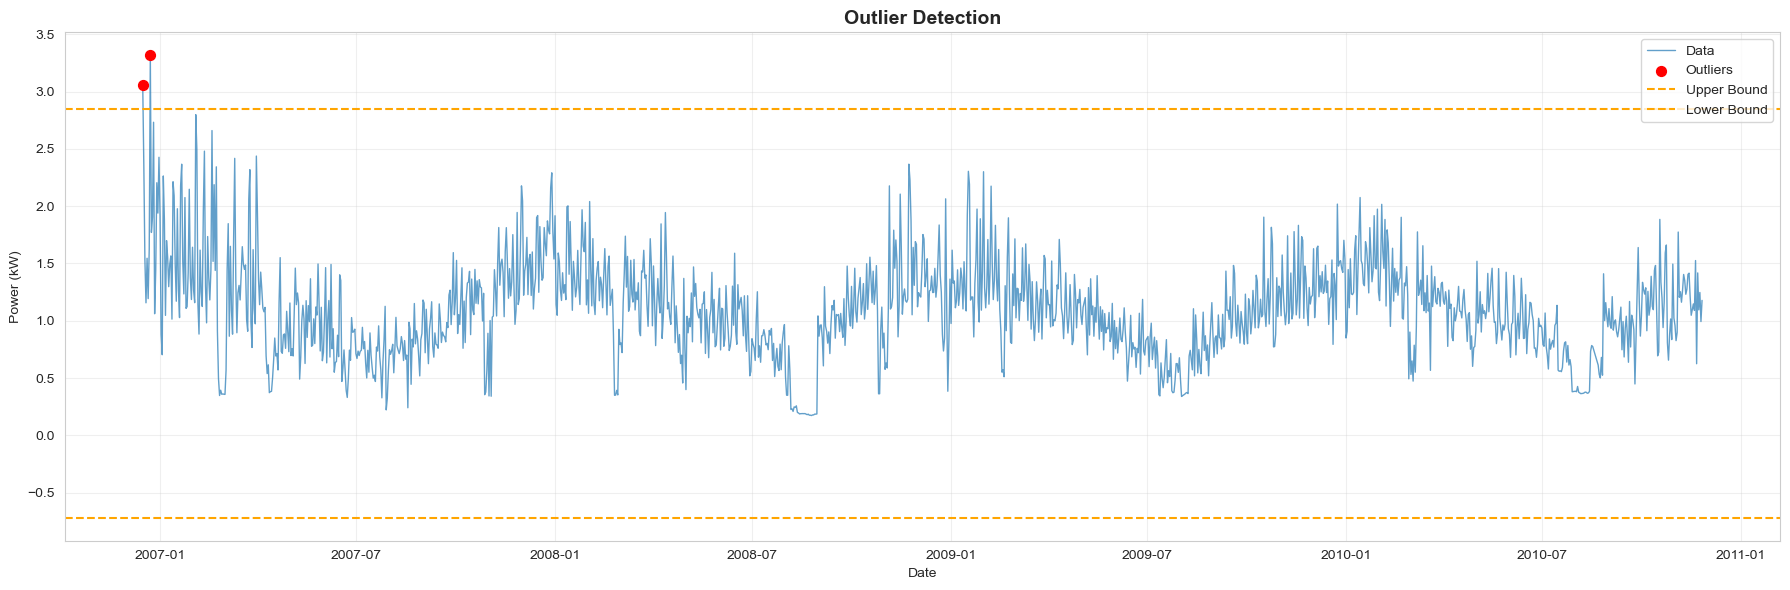

In [10]:
# Detect outliers using IQR method
Q1 = daily_df_filled[target].quantile(0.25)
Q3 = daily_df_filled[target].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR  # Using 3*IQR for less aggressive filtering
upper_bound = Q3 + 3 * IQR

outlier_mask = (daily_df_filled[target] < lower_bound) | (daily_df_filled[target] > upper_bound)
print(f"Outliers detected: {outlier_mask.sum()} ({outlier_mask.sum()/len(daily_df_filled)*100:.2f}%)")

# Visualize outliers
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(daily_df_filled.index, daily_df_filled[target], label='Data', linewidth=1, alpha=0.7)
ax.scatter(daily_df_filled.index[outlier_mask], daily_df_filled[target][outlier_mask], 
           c='red', s=50, label='Outliers', zorder=5)
ax.axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound')
ax.axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound')
ax.set_title('Outlier Detection', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Keep outliers but flag them (useful for robust modeling)
daily_df_filled['is_outlier'] = outlier_mask

## 8. Feature Engineering

In [11]:
# Create temporal features
daily_df_filled['dayofweek'] = daily_df_filled.index.dayofweek
daily_df_filled['day'] = daily_df_filled.index.day
daily_df_filled['month'] = daily_df_filled.index.month
daily_df_filled['quarter'] = daily_df_filled.index.quarter
daily_df_filled['year'] = daily_df_filled.index.year
daily_df_filled['dayofyear'] = daily_df_filled.index.dayofyear
daily_df_filled['weekofyear'] = daily_df_filled.index.isocalendar().week

# Binary features
daily_df_filled['is_weekend'] = (daily_df_filled['dayofweek'] >= 5).astype(int)
daily_df_filled['is_month_start'] = daily_df_filled.index.is_month_start.astype(int)
daily_df_filled['is_month_end'] = daily_df_filled.index.is_month_end.astype(int)

# Cyclical encoding for periodic features
daily_df_filled['dayofweek_sin'] = np.sin(2 * np.pi * daily_df_filled['dayofweek'] / 7)
daily_df_filled['dayofweek_cos'] = np.cos(2 * np.pi * daily_df_filled['dayofweek'] / 7)
daily_df_filled['month_sin'] = np.sin(2 * np.pi * daily_df_filled['month'] / 12)
daily_df_filled['month_cos'] = np.cos(2 * np.pi * daily_df_filled['month'] / 12)
daily_df_filled['dayofyear_sin'] = np.sin(2 * np.pi * daily_df_filled['dayofyear'] / 365)
daily_df_filled['dayofyear_cos'] = np.cos(2 * np.pi * daily_df_filled['dayofyear'] / 365)

print("Temporal features created")
print(f"New shape: {daily_df_filled.shape}")

Temporal features created
New shape: (1442, 24)


In [12]:
# Create lag features
lags = [1, 2, 3, 7, 14, 30]
for lag in lags:
    daily_df_filled[f'{target}_lag_{lag}'] = daily_df_filled[target].shift(lag)

print(f"Lag features created: {lags}")

Lag features created: [1, 2, 3, 7, 14, 30]


In [13]:
# Create rolling statistics features
windows = [7, 14, 30]
for window in windows:
    daily_df_filled[f'{target}_rolling_mean_{window}'] = daily_df_filled[target].rolling(window=window).mean()
    daily_df_filled[f'{target}_rolling_std_{window}'] = daily_df_filled[target].rolling(window=window).std()
    daily_df_filled[f'{target}_rolling_min_{window}'] = daily_df_filled[target].rolling(window=window).min()
    daily_df_filled[f'{target}_rolling_max_{window}'] = daily_df_filled[target].rolling(window=window).max()

print(f"Rolling statistics created for windows: {windows}")

Rolling statistics created for windows: [7, 14, 30]


In [14]:
# Exponentially weighted features
daily_df_filled[f'{target}_ewm_7'] = daily_df_filled[target].ewm(span=7, adjust=False).mean()
daily_df_filled[f'{target}_ewm_30'] = daily_df_filled[target].ewm(span=30, adjust=False).mean()

# Differencing features
daily_df_filled[f'{target}_diff_1'] = daily_df_filled[target].diff(1)
daily_df_filled[f'{target}_diff_7'] = daily_df_filled[target].diff(7)

print("Additional features created")
print(f"Final shape: {daily_df_filled.shape}")
print(f"Total features: {len(daily_df_filled.columns)}")

Additional features created
Final shape: (1442, 46)
Total features: 46


## 9. Feature Visualization

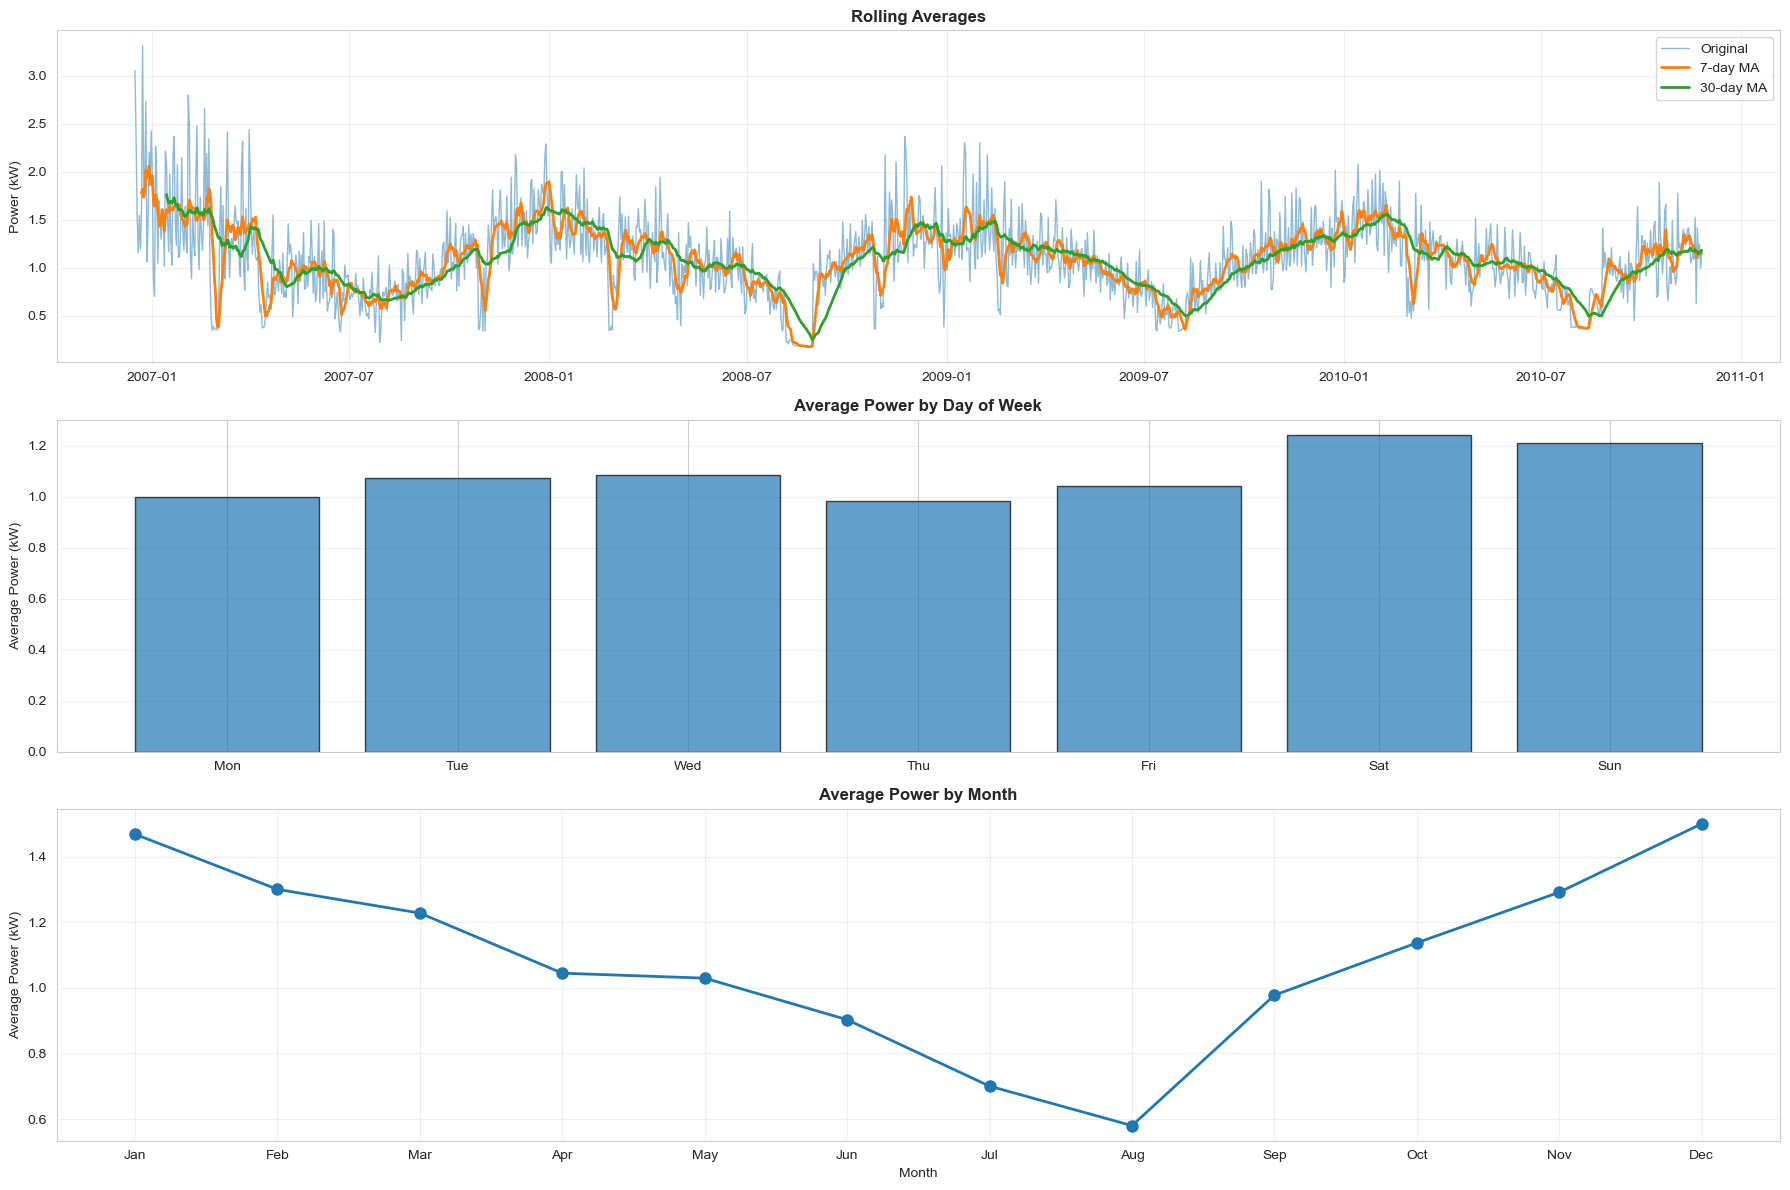

In [15]:
# Visualize some engineered features
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Original with rolling means
axes[0].plot(daily_df_filled.index, daily_df_filled[target], label='Original', alpha=0.5, linewidth=1)
axes[0].plot(daily_df_filled.index, daily_df_filled[f'{target}_rolling_mean_7'], label='7-day MA', linewidth=2)
axes[0].plot(daily_df_filled.index, daily_df_filled[f'{target}_rolling_mean_30'], label='30-day MA', linewidth=2)
axes[0].set_title('Rolling Averages', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Weekly pattern (average by day of week)
weekly_pattern = daily_df_filled.groupby('dayofweek')[target].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), weekly_pattern.values, alpha=0.7, edgecolor='black')
axes[1].set_title('Average Power by Day of Week', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)
axes[1].set_ylabel('Average Power (kW)')
axes[1].grid(True, alpha=0.3, axis='y')

# Monthly pattern
monthly_pattern = daily_df_filled.groupby('month')[target].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].plot(range(1, 13), monthly_pattern.values, marker='o', linewidth=2, markersize=8)
axes[2].set_title('Average Power by Month', fontsize=12, fontweight='bold')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names)
axes[2].set_ylabel('Average Power (kW)')
axes[2].set_xlabel('Month')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Train/Validation/Test Split

Use time-based splitting to preserve temporal order.

In [16]:
# Remove rows with NaN values created by feature engineering
df_clean = daily_df_filled.dropna()
print(f"Shape after removing NaN from feature engineering: {df_clean.shape}")

# Define split points
n_total = len(df_clean)
n_test = 60  # Last 60 days for testing (2 months)
n_val = 60   # 60 days before test for validation
n_train = n_total - n_test - n_val

train_df = df_clean.iloc[:n_train]
val_df = df_clean.iloc[n_train:n_train+n_val]
test_df = df_clean.iloc[n_train+n_val:]

print(f"\nDataset splits:")
print(f"Train: {len(train_df)} days ({train_df.index.min()} to {train_df.index.max()})")
print(f"Validation: {len(val_df)} days ({val_df.index.min()} to {val_df.index.max()})")
print(f"Test: {len(test_df)} days ({test_df.index.min()} to {test_df.index.max()})")
print(f"Total: {len(df_clean)} days")

Shape after removing NaN from feature engineering: (1412, 46)

Dataset splits:
Train: 1292 days (2007-01-15 00:00:00 to 2010-07-29 00:00:00)
Validation: 60 days (2010-07-30 00:00:00 to 2010-09-27 00:00:00)
Test: 60 days (2010-09-28 00:00:00 to 2010-11-26 00:00:00)
Total: 1412 days


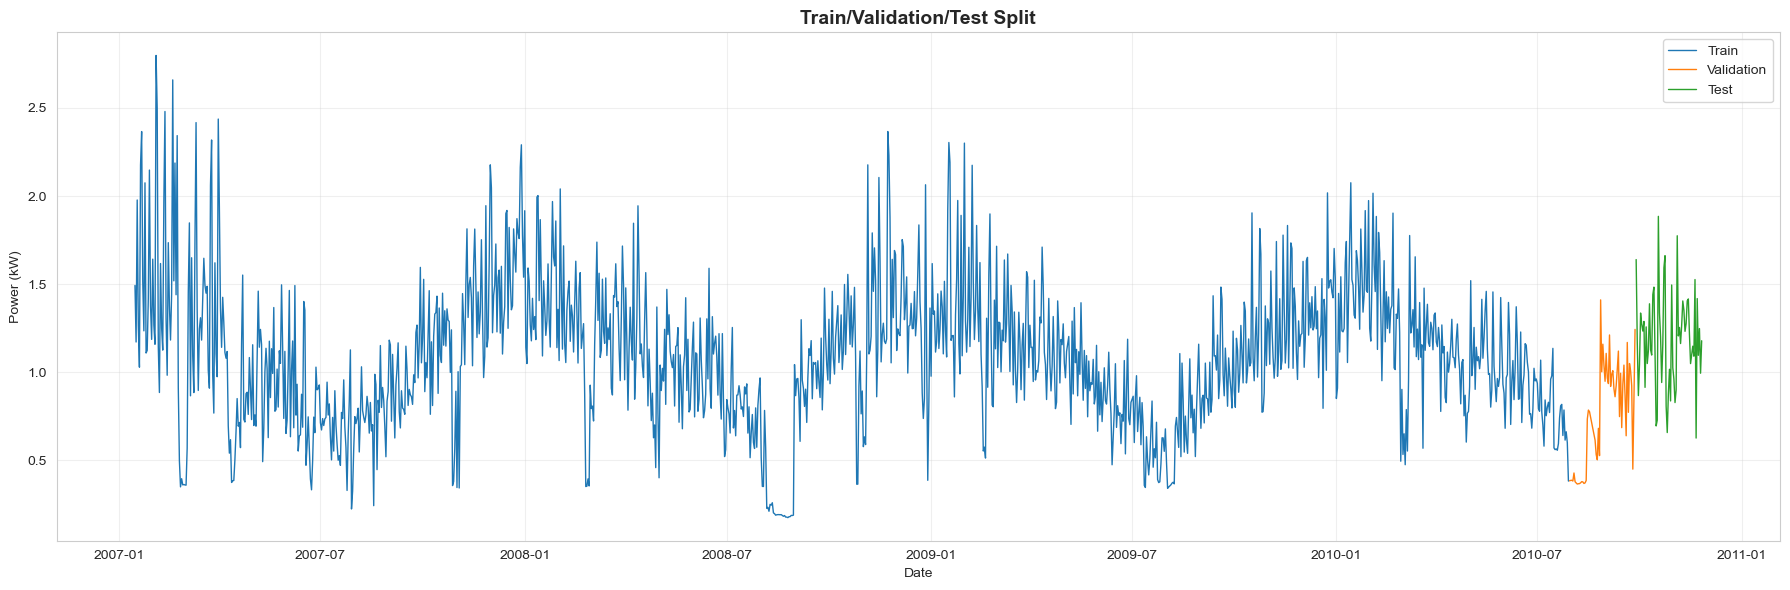

In [17]:
# Visualize splits
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(train_df.index, train_df[target], label='Train', linewidth=1)
ax.plot(val_df.index, val_df[target], label='Validation', linewidth=1)
ax.plot(test_df.index, test_df[target], label='Test', linewidth=1)
ax.set_title('Train/Validation/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Save Processed Data

In [18]:
# Save complete processed dataset
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

df_clean.to_parquet(output_dir / 'daily_features.parquet')
print(f"Saved processed data to {output_dir / 'daily_features.parquet'}")

# Save splits separately
train_df.to_parquet(output_dir / 'train.parquet')
val_df.to_parquet(output_dir / 'val.parquet')
test_df.to_parquet(output_dir / 'test.parquet')
print(f"Saved train/val/test splits to {output_dir}")

# Save feature names
feature_cols = [col for col in df_clean.columns if col != target and col != 'is_outlier']
with open(output_dir / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_cols))
print(f"Saved {len(feature_cols)} feature names")

Saved processed data to ../data/processed/daily_features.parquet
Saved train/val/test splits to ../data/processed
Saved 44 feature names


## Summary

### Data Processing Steps Completed:
1. ✅ Loaded and cleaned raw data
2. ✅ Aggregated minute-level to daily data
3. ✅ Handled missing values through interpolation
4. ✅ Performed time series decomposition (trend, seasonal, residual)
5. ✅ Tested stationarity (ADF and KPSS tests)
6. ✅ Analyzed autocorrelation patterns
7. ✅ Detected and flagged outliers
8. ✅ Created comprehensive features:
   - Temporal features (day, month, year, etc.)
   - Cyclical encodings (sin/cos transformations)
   - Lag features (1, 2, 3, 7, 14, 30 days)
   - Rolling statistics (mean, std, min, max)
   - Exponential weighted averages
   - Differencing features
9. ✅ Split data into train/validation/test sets
10. ✅ Saved processed datasets

### Key Insights:
- Strong weekly seasonality detected
- Series is non-stationary but becomes stationary after first differencing
- Clear temporal patterns (hourly, daily, weekly, monthly)
- Minimal missing values successfully handled
- Outliers present but retained for robust modeling

### Next Steps:
Proceed to notebook 03_classical_models.ipynb to train and evaluate forecasting models.